### Further clean SPEND & PAYMENT variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from itertools import compress
from pandarallel import pandarallel
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PowerTransformer
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, print_percentile,
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, describe_all, check_psi, plot_heatmap
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, check_roc_auc,
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

56

In [6]:
START = time.time()

### Read Data

In [7]:
%%time
train = read_file(f"../{RAW_DATA_PATH}/train_parquet_rounded/spend_payment.parquet")
test = read_file(f"../{RAW_DATA_PATH}/test_parquet_rounded/spend_payment.parquet")

Shape of data: (5531451, 29)
Shape of data: (11363762, 28)
CPU times: user 8.26 s, sys: 4.47 s, total: 12.7 s
Wall time: 4.35 s


In [8]:
# %%time
# labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
# if "target" not in train.columns:
#     train = train.merge(labels, on="customer_ID", how="left")

In [9]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 5.15 s, sys: 640 ms, total: 5.79 s
Wall time: 5.77 s


In [10]:
del test

In [11]:
train.shape, public_test.shape, private_test.shape

((5531451, 29), (5719469, 28), (5644293, 28))

In [12]:
spend_payment_variables = get_cols(train, ["P_", "S_"])

In [13]:
print(sorted(spend_payment_variables))

['P_2', 'P_3', 'P_4', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_2', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9']


In [14]:
df_list = [train, public_test, private_test]

In [15]:
# for df in df_list:
#     insert_row_number(df)

In [16]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
# train_corr = train.loc[:, train.columns[4:-1]].corr()
# train_corr.to_csv(f"../{RAW_DATA_PATH}/pre_clean_train_spend_payment_corr.csv", index=False)

In [18]:
# train_corr = read_file(f"../{RAW_DATA_PATH}/pre_clean_train_spend_payment_corr.csv")
# train_corr.index = train_corr.columns

In [19]:
# plot_heatmap(train_corr, figsize=(19, 12), fmt=".2f", annot=True)

### Rounding

#### Round to 2 decimals

In [20]:
# %%time
# # Skip some columns
# ignore_list = ["S_2"]
# col_to_round = list(set(spend_payment_variables) - set(ignore_list))

# sp_variables_psi_list = []
# for col in tqdm(col_to_round):
#     pre_round = check_psi(df_list, col)[1]
#     df_list = round_dfs(df_list, col, decimals=2, add_new_col=False, nb_workers=8)
#     post_round = check_psi(df_list, col)[1]
#     sp_variables_psi_list.append((col, pre_round, post_round))

# sp_psi_df = pd.DataFrame(sp_variables_psi_list, columns=["feature", "psi_before", "psi_after"])

# print(sp_psi_df.loc[sp_psi_df["psi_before"] < sp_psi_df["psi_after"]])

# train = df_list[0]
# test = pd.concat(df_list[1:], axis=0)
# test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

# train.shape, test.shape

# sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

# train.columns

# train.to_parquet(f"../{RAW_TRAIN_PARQUET_PATH}/spend_payment_.parquet")
# test.to_parquet(f"../{RAW_TEST_PARQUET_PATH}/spend_payment_.parquet")

### P_2 @Continuous, Decreasing

In [21]:
# plot_target_check(train, "P_2", q=50, use_raw_bin=True)

In [22]:
describe_all(df_list, "P_2")

,train,public test,private test
count,"5,485,466.0000","5,685,852.0000","5,618,032.0000"
mean,0.6513,0.6501,0.6553
std,0.2447,0.2475,0.2463
min,-0.4600,-0.4400,-0.4700
25%,0.4800,0.4800,0.4900
50%,0.6900,0.6900,0.7000
75%,0.8600,0.8600,0.8600
max,1.0000,1.0000,1.0000
null_proportion,0.0083,0.0059,0.0047


In [23]:
print_percentile(df_list, "P_2", 0.01)

0.01th percentile:
train : -0.29
public test : -0.29
private test : -0.28


In [24]:
for df in df_list:
    df = clip_col(df, "P_2", btm_value=-0.29, add_new_col=False)

45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1


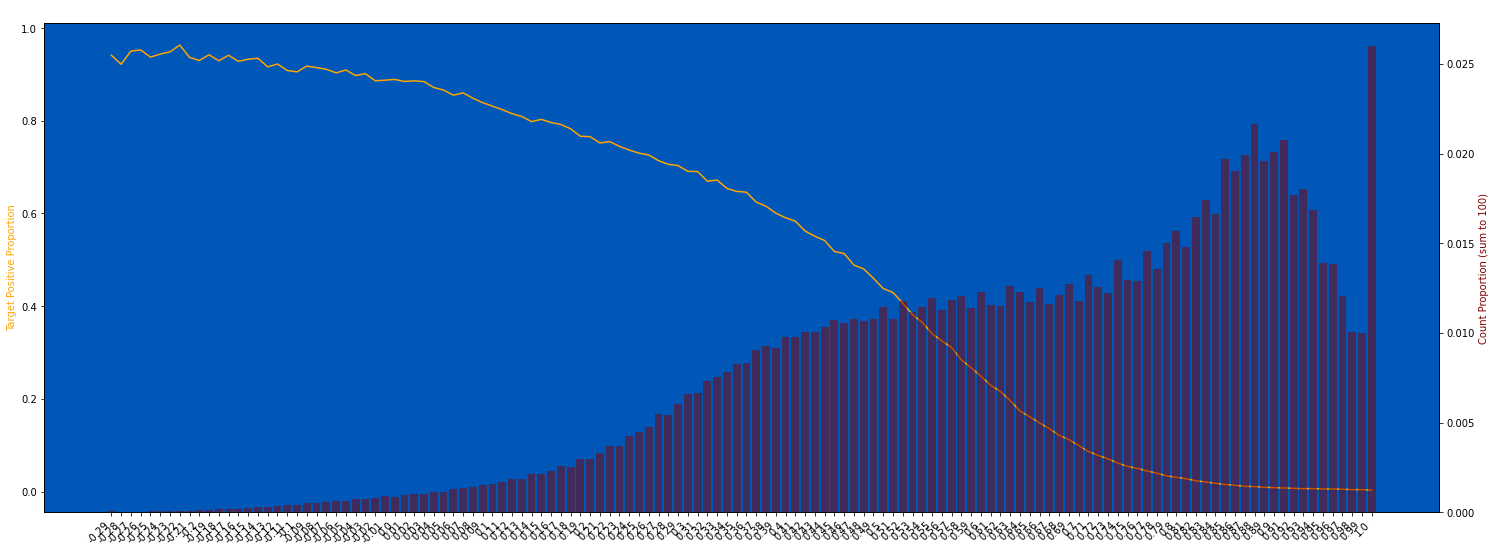

In [25]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True, nunique_thr=150, strfy_x=True, figsize=(25, 10), without_drop_tail=True)

In [26]:
# plot_train_test_distribution(df_list, "P_2", nunique_thr=150, figsize=(24, 9), without_drop_tail=True)

### P_3a @Created, Continuous

In [27]:
# for p in np.arange(2.8, 4, 0.05):
#     def calc(x):
#         if x >= 0.618:
#             return (x - 0.618) / p
#         else:
#             return (0.618 - x)

#     for df in df_list:
#         df["P_3a"] = df["P_3"].parallel_apply(lambda x: calc(x)).round(2)
        
#     print(p, check_roc_auc(train, "P_3a"))

In [28]:
def calc(x):
    p = 0.624
    q = 4
    if x >= p:
        return (x - p) / q
    else:
        return (p - x)

In [29]:
for df in df_list:
    df["P_3a"] = df["P_3"].parallel_apply(lambda x: calc(x)).round(2)
    df = clip_col(df, "P_3a", add_new_col=False, top_value=1)

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


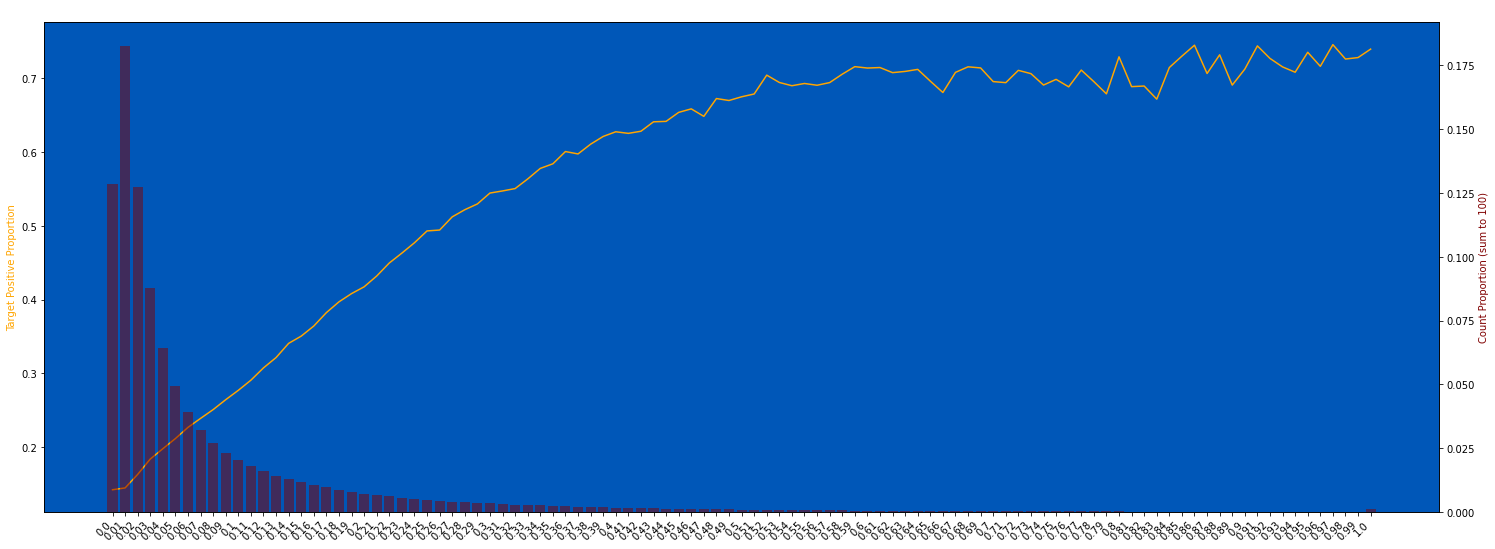

In [30]:
plot_target_check(train, "P_3a", q=50, use_raw_bin=True, nunique_thr=340, strfy_x=True, 
                  figsize=(25, 10), without_drop_tail=True)

In [31]:
# plot_train_test_distribution(df_list, "P_3a", nunique_thr=340, figsize=(24, 10), without_drop_tail=True)

### P_3 @Continous

In [32]:
# plot_target_check(train, "P_3", q=50, use_raw_bin=True)

In [33]:
print_percentile(df_list, "P_3", 0.01)
describe_all(df_list, "P_3")

0.01th percentile:
train : -0.76
public test : -0.78
private test : -0.78


,train,public test,private test
count,"5,229,959.0000","5,477,221.0000","5,437,962.0000"
mean,0.5963,0.5937,0.5942
std,0.1708,0.1726,0.1709
min,-1.5200,-1.5100,-1.4300
25%,0.5400,0.5300,0.5300
50%,0.6100,0.6100,0.6100
75%,0.6800,0.6800,0.6800
max,2.4200,2.6300,2.4800
null_proportion,0.0545,0.0424,0.0366


In [34]:
for df in df_list:
    df = clip_col(df, "P_3", top_value=1.6, add_new_col=False)
    df = clip_col(df, "P_3", btm_value=-0.78, add_new_col=False)

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


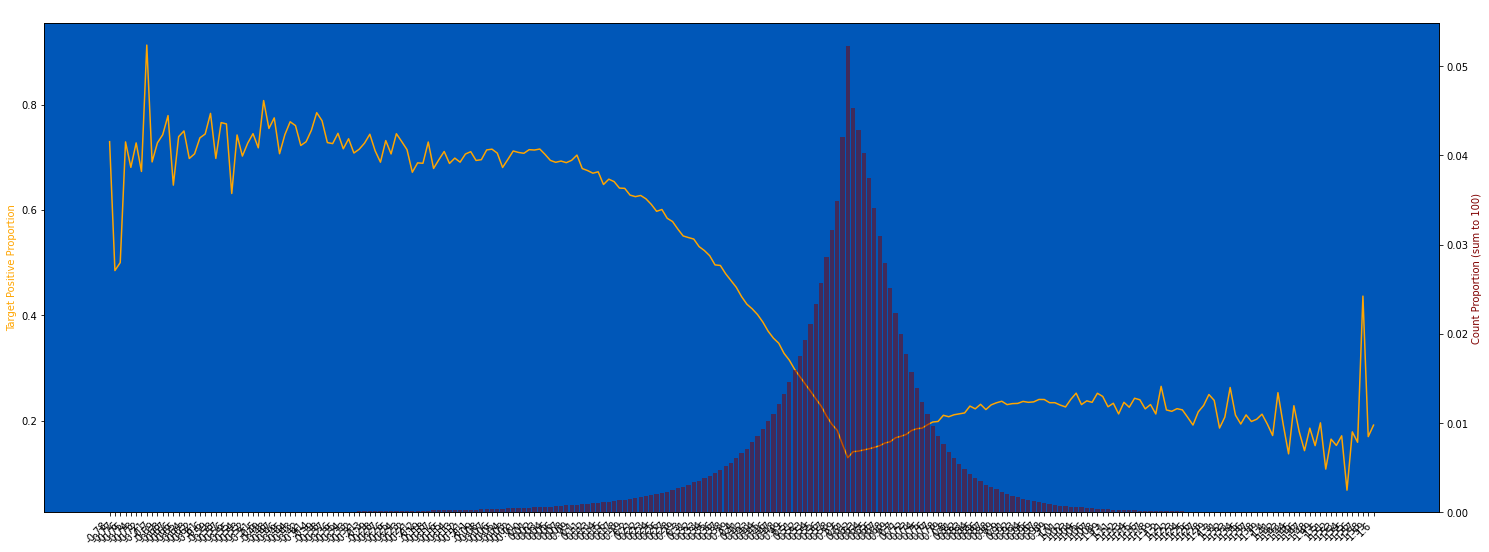

In [35]:
plot_target_check(train, "P_3", q=50, use_raw_bin=True, nunique_thr=340, strfy_x=True, 
                  figsize=(25, 10), percentile_drop=2)

In [36]:
# plot_train_test_distribution(df_list, "P_3", nunique_thr=340, figsize=(24, 10))

### P_4 @Continuous

In [37]:
# plot_target_check(train, "P_4", q=50, use_raw_bin=True)

In [38]:
%%time
df_list = fill_nans(df_list, col="P_4", tuple_of_values=(0, 0.01), add_new_col=False)

CPU times: user 404 ms, sys: 304 ms, total: 708 ms
Wall time: 707 ms


In [39]:
for df in df_list:
    df["P_4"] -= 0.76

In [40]:
print_percentile(df_list, "P_4", 0.01)
describe_all(df_list, "P_4")

0.01th percentile:
train : 0.06894399999999999
public test : 0.07999999999999996
private test : 0.09999999999999998


,train,public test,private test
count,"798,945.0000","718,921.0000","646,073.0000"
mean,0.2018,0.1973,0.1968
std,0.0262,0.0139,0.0110
min,0.0100,0.0200,0.0300
25%,0.1900,0.1900,0.1900
50%,0.2000,0.2000,0.2000
75%,0.2000,0.2000,0.2000
max,0.5000,0.4600,0.4700
null_proportion,0.8556,0.8743,0.8855


In [41]:
for df in df_list:
    df = clip_col(df, "P_4", top_value=0.36, add_new_col=False)
    df = clip_col(df, "P_4", btm_value=0.07, add_new_col=False)

4732506 null count, 0.856 null proportion
0.2073 of the targets have label = 1


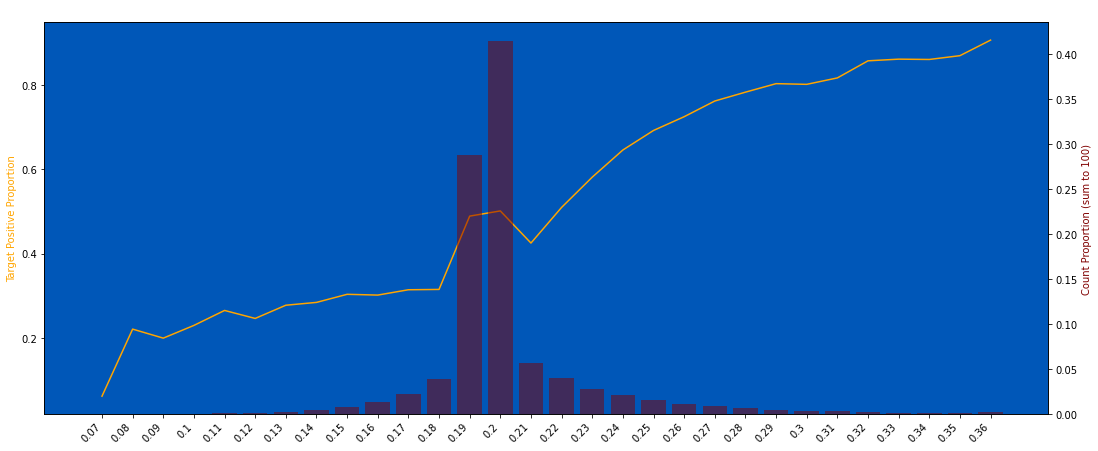

In [42]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

Train-Public PSI: 0.0578, Train-Private PSI: 0.0910


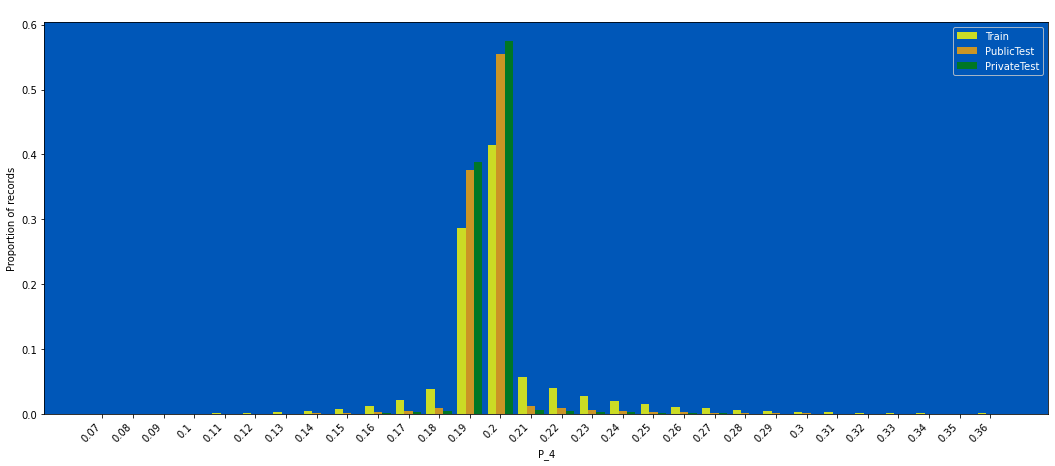

In [43]:
plot_train_test_distribution(df_list, "P_4", without_drop_tail=True)

### S_3 @Continuous, Increasing

In [44]:
# plot_target_check(train, "S_3", q=50, use_raw_bin=True)

In [45]:
print_percentile(df_list, "S_3", 0.1)
describe_all(df_list, "S_3")

0.1th percentile:
train : -0.1
public test : -0.11
private test : -0.12


,train,public test,private test
count,"4,510,907.0000","4,794,690.0000","4,828,107.0000"
mean,0.2208,0.2247,0.2201
std,0.1934,0.2005,0.1971
min,-0.6300,-0.6900,-0.6600
25%,0.1200,0.1200,0.1200
50%,0.1600,0.1600,0.1600
75%,0.2500,0.2600,0.2500
max,5.4800,4.1500,4.3400
null_proportion,0.1845,0.1617,0.1446


In [46]:
for df in df_list:
    df = clip_col(df, "S_3", top_value=1.68, add_new_col=False)
    df = clip_col(df, "S_3", btm_value=-0.12, add_new_col=False)

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


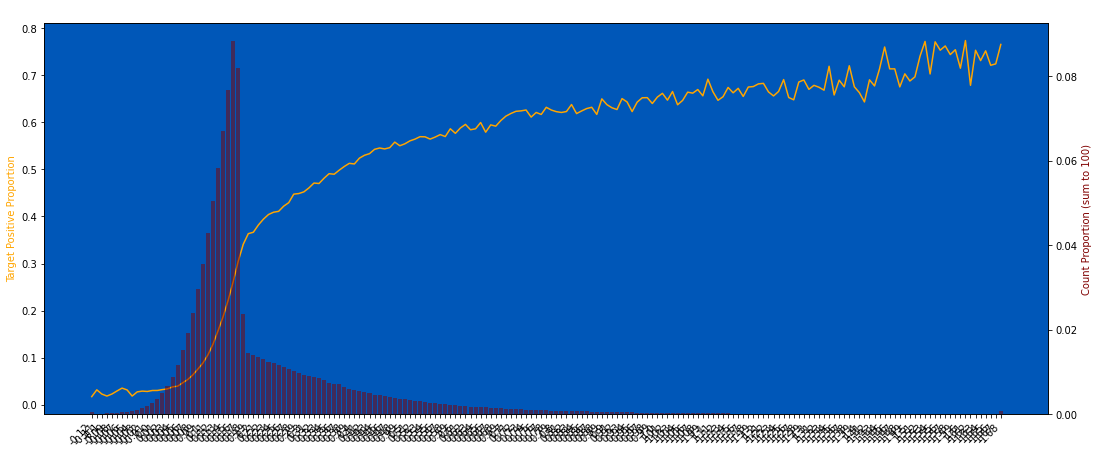

In [47]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True, nunique_thr=700, strfy_x=True, percentile_drop=0.5)

In [48]:
# plot_train_test_distribution(df_list, "S_3", nunique_thr=500)

### S_5 @Continuous, Increasing

In [49]:
# plot_target_check(train, "S_5", q=50, use_raw_bin=True)

In [50]:
print_percentile(df_list, "S_5", 99.9)
describe_all(df_list, "S_5")

99.9th percentile:
train : 3.36
public test : 3.54
private test : 3.7


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0831,0.0830,0.0839
std,0.4074,0.3772,0.5873
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0100,0.0100,0.0100
75%,0.0700,0.0600,0.0600
max,206.8700,119.4300,594.8800
null_proportion,0.0000,0.0000,0.0000


In [51]:
for df in df_list:
    df = clip_col(df, "S_5", top_value=3.5, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


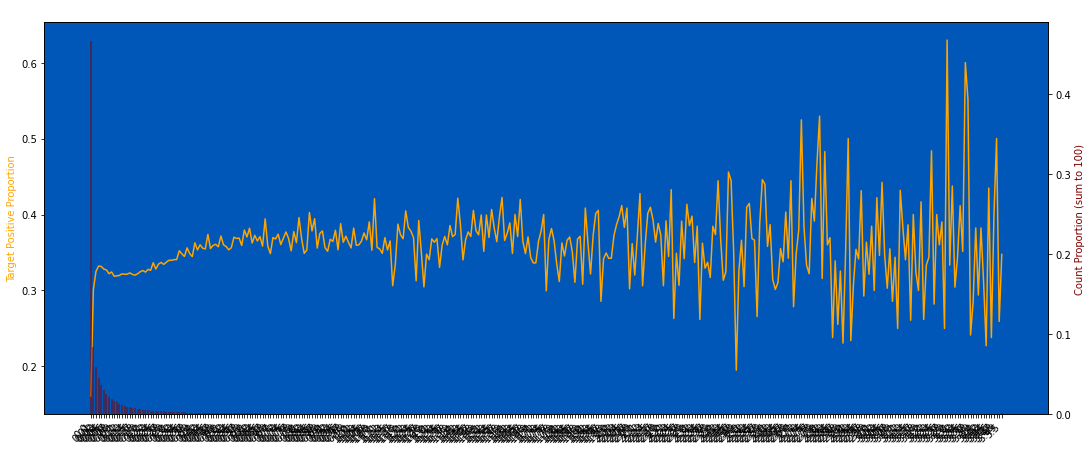

In [52]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [53]:
# plot_train_test_distribution(df_list, "S_5", nunique_thr=5000)

### S_6 @Binary, Decreasing

In [54]:
# plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True)

In [55]:
for df in df_list:
    df["S_6"] = integerize(df["S_6"])

0 null count, 0.000 null proportion
nan of the targets have label = 1


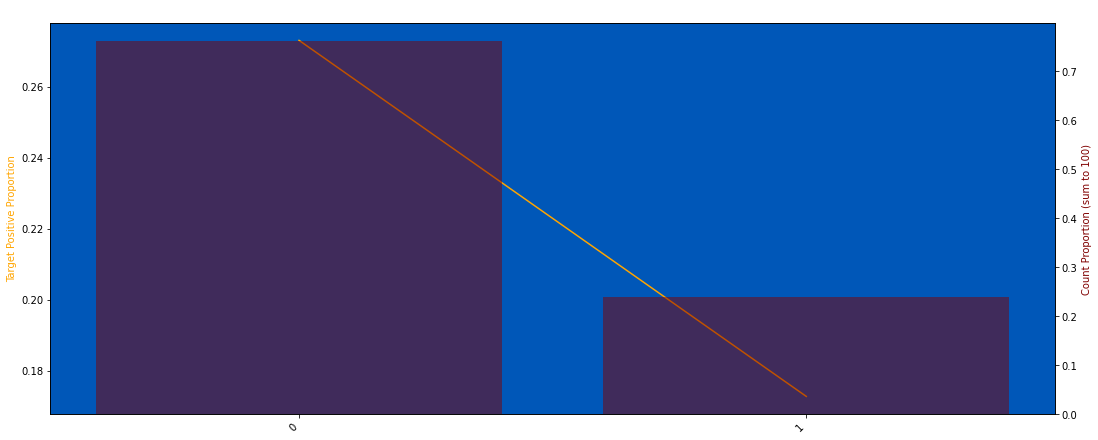

In [56]:
plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [57]:
# plot_train_test_distribution(df_list, "S_6", nunique_thr=50)

### S_7 @Continuous, Increasing

In [58]:
# plot_target_check(train, "S_7", q=50, use_raw_bin=True)

In [59]:
print_percentile(df_list, "S_7", 0.1)
describe_all(df_list, "S_7")

0.1th percentile:
train : -0.07
public test : -0.08
private test : -0.09


,train,public test,private test
count,"4,510,907.0000","4,794,690.0000","4,828,107.0000"
mean,0.2181,0.2139,0.2058
std,0.2063,0.2051,0.1982
min,-0.4800,-0.5200,-0.4900
25%,0.0900,0.0900,0.0900
50%,0.1300,0.1300,0.1200
75%,0.2900,0.2800,0.2700
max,3.9400,3.3900,3.3900
null_proportion,0.1845,0.1617,0.1446


In [60]:
for df in df_list:
    df = clip_col(df, "S_7", top_value=1.5, add_new_col=False)
    df = clip_col(df, "S_7", btm_value=-0.09, add_new_col=False)

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


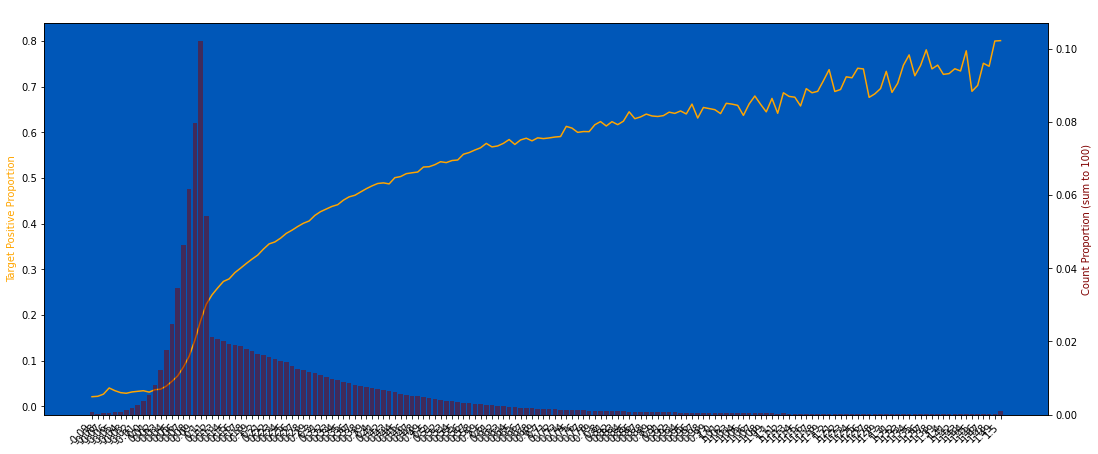

In [61]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True, nunique_thr=360, strfy_x=True)

In [62]:
# plot_train_test_distribution(df_list, "S_7", nunique_thr=5000)

### S_8 @Continuous, Decreasing

In [63]:
# plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [64]:
%%time
df_list = fill_nans(df_list, col="S_8", tuple_of_values=(0), add_new_col=False)

CPU times: user 335 ms, sys: 203 ms, total: 539 ms
Wall time: 538 ms


In [65]:
for df in df_list:
    df["S_8"] = df["S_8"].replace(
        (0.11, 0.17, 0.25, 0.31, 0.33, 0.35, 0.41, 0.45, 0.47, 0.49, 
         0.59, 0.61, 0.67, 0.71, 0.75, 0.85, 0.91, 0.93, 0.94, 1.01, 1.11, 1.14, 1.15, 1.23),
        (0.12, 0.16, 0.24, 0.32, 0.32, 0.36, 0.4, 0.46, 0.46, 0.48, 
         0.6, 0.6, 0.66, 0.7, 0.74, 0.86, 0.92, 0.92, 0.92, 1.02, 1.1, 1.16, 1.16, 1.22)
    )

1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1


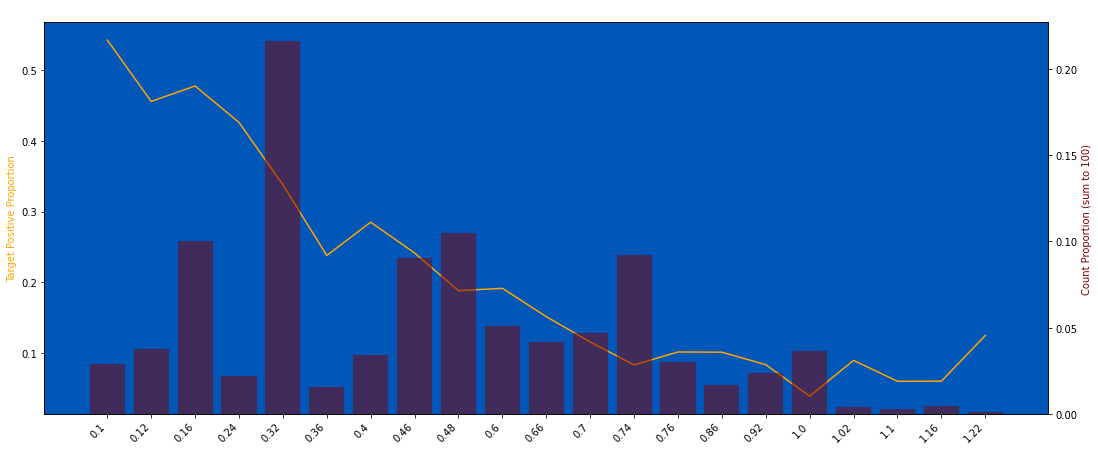

In [66]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [67]:
# plot_train_test_distribution(df_list, "S_8", nunique_thr=500, without_drop_tail=True)

### S_9 (Drop due to train test drift)

In [68]:
for df in tqdm(df_list):
    df.drop(columns="S_9", errors="ignore", inplace=True)

100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


### S_11 (Drop due to train test drift)

In [69]:
for df in tqdm(df_list):
    df.drop(columns="S_11", errors="ignore", inplace=True)

100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


### S_12 @Continuous, U shape

In [70]:
# plot_target_check(train, "S_12", q=50, use_raw_bin=True)

In [71]:
print_percentile(df_list, "S_12", 99.9)
describe_all(df_list, "S_12")

99.9th percentile:
train : 2.49
public test : 2.53
private test : 2.48


,train,public test,private test
count,"5,531,451.0000","5,718,319.0000","5,643,058.0000"
mean,0.2355,0.2356,0.2368
std,0.2507,0.2546,0.2557
min,-0.4100,-0.4100,-0.4100
25%,0.1800,0.1800,0.1800
50%,0.1900,0.1900,0.1900
75%,0.2000,0.2000,0.2100
max,175.3300,192.6200,159.6400
null_proportion,0.0000,0.0002,0.0002


In [72]:
for df in df_list:
    df = clip_col(df, "S_12", top_value=2.5, add_new_col=False)
    df = clip_col(df, "S_12", btm_value=-0.36, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


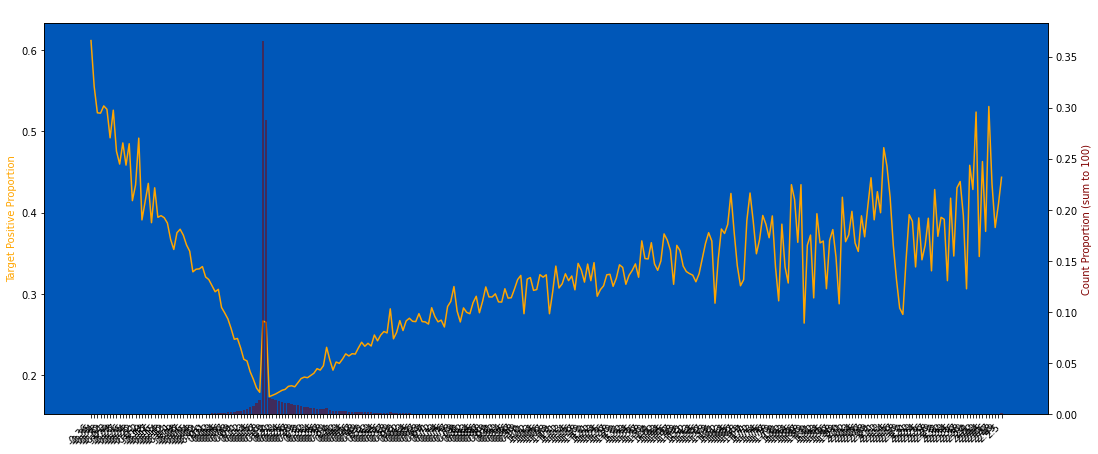

In [73]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [74]:
# plot_train_test_distribution(df_list, "S_12", nunique_thr=50000)

### S_13 @Integer, Decreasing

In [75]:
# plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

In [76]:
mapping_dict = {0.03: 1, 0.04: 1, 0.28: 2, 0.29: 2, 0.4 : 3, 0.41: 3, 0.42: 3, 0.43: 3, 
                0.5 : 4, 0.51: 4, 0.52: 5, 0.53: 5, 0.55: 6, 0.56: 6, 0.62: 7, 0.63: 7, 
                0.67: 8, 0.68: 8, 0.69: 9, 0.84: 10, 0.85: 10, 1: 11}

In [77]:
for df in df_list:
    df["S_13"] = df["S_13"].map(mapping_dict)

2822865 null count, 0.510 null proportion
0.2769 of the targets have label = 1


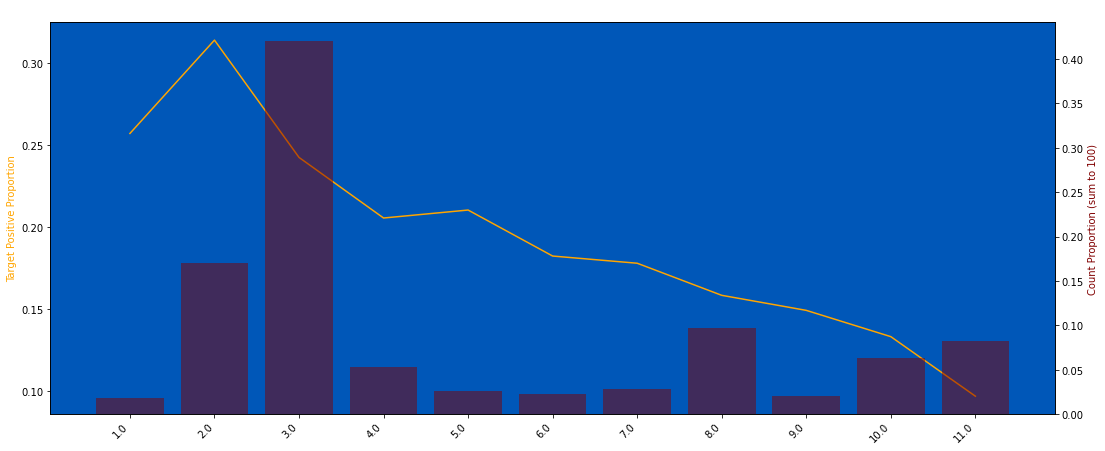

In [78]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0397, Train-Private PSI: 0.0958
Bottom 1% and Top 1% are dropped from this chart


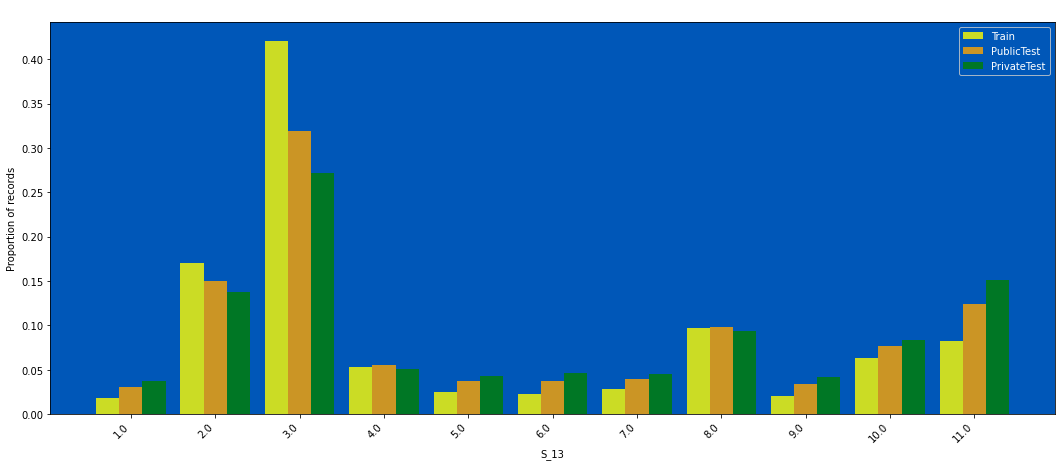

In [79]:
plot_train_test_distribution(df_list, "S_13", nunique_thr=50000)

### S_15 @Continuous, Increasing

In [80]:
# plot_target_check(train, "S_15", q=50, use_raw_bin=True)

In [81]:
# for df in df_list:
#     df.loc[df["S_15"].between(0.5, 0.51), "S_15"] = np.nan

In [82]:
# for col in train.columns[2:]:
#     if col == "temp":
#         continue
#     corrcoef = train[["S_15_", col]].dropna().corr().iloc[0, 1]
#     if abs(corrcoef) >= 0.3:
#         print(col, corrcoef)

**Comments:**
- S_8 has the highest (absolute) correlation with S_15, use this information to cross validate the 0.5 - 0.51

In [83]:
train["S_8"].describe()

count   3,722,971.0000
mean            0.4774
std             0.2479
min             0.1000
25%             0.3200
50%             0.4600
75%             0.7000
max             1.2200
Name: S_8, dtype: float64

In [84]:
train.loc[train["S_8"].isnull(), "S_15"].describe()

count   1,808,480.0000
mean            0.5212
std             0.1140
min             0.5000
25%             0.5000
50%             0.5000
75%             0.5000
max             5.3000
Name: S_15, dtype: float64

In [85]:
np.percentile(train.loc[train["S_8"].isnull(), "S_15"].dropna(), 0)

0.5

In [86]:
np.percentile(train.loc[train["S_8"].isnull(), "S_15"].dropna(), 95)

0.6

**Comments:**
- When S_8 is null, S_15 is likely to be 0.5 (about 93% of them)
- Replace those S_15 (0.5 - 0.51) with NaN

In [87]:
for df in df_list:
    df.loc[df["S_8"].isnull(), "S_15"] = np.nan

In [88]:
for df in df_list:
    df["S_15"] = df["S_15"].abs()

In [89]:
print_percentile(df_list, "S_15", 99.9)
describe_all(df_list, "S_15")

99.9th percentile:
train : 1.5
public test : 1.5
private test : 1.6


,train,public test,private test
count,"3,722,971.0000","3,948,039.0000","3,990,462.0000"
mean,0.2982,0.2863,0.2802
std,0.1804,0.1819,0.1824
min,0.0000,0.0000,0.0000
25%,0.2000,0.2000,0.2000
50%,0.3000,0.3000,0.3000
75%,0.4000,0.4000,0.4000
max,5.3000,7.0000,8.3000
null_proportion,0.3269,0.3097,0.2930


In [90]:
for df in df_list:
    df = clip_col(df, "S_15", top_value=1.6, add_new_col=False)
    df["S_15"] += 0.1

1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1


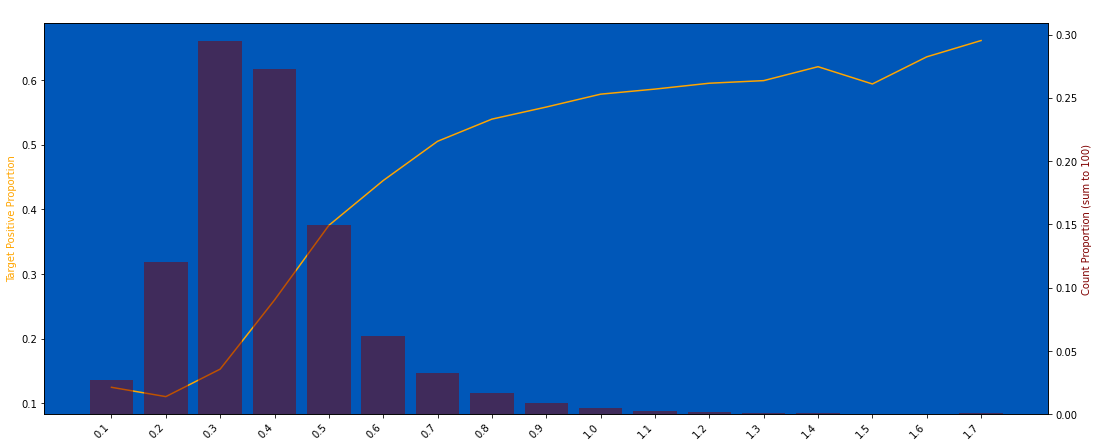

In [91]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [92]:
# plot_train_test_distribution(df_list, "S_15", nunique_thr=500, without_drop_tail=True)

### S_16 @Continuous, Increasing

In [93]:
# plot_target_check(train, "S_16", q=50, use_raw_bin=True)

In [94]:
print_percentile(df_list, "S_16", 99.9)
describe_all(df_list, "S_16")

99.9th percentile:
train : 8.4
public test : 9.34
private test : 9.1


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0458,0.0487,0.0457
std,0.7725,0.8653,0.9164
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,231.7500,236.3500,365.1700
null_proportion,0.0000,0.0000,0.0000


In [95]:
for df in df_list:
    df = clip_col(df, "S_16", top_value=9, add_new_col=False)
    df["S_16"] = df["S_16"].replace(0, np.nan)

In [96]:
df_list = round_dfs(df_list, "S_16", decimals=2, add_new_col=False, nb_workers=12)

5418175 null count, 0.980 null proportion
0.2390 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


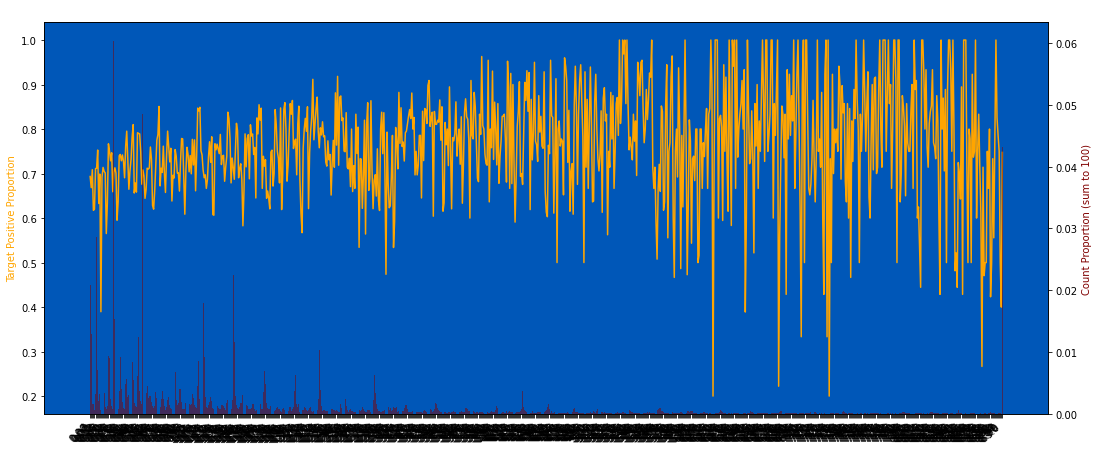

In [97]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True, without_drop_tail=False)

In [98]:
# plot_train_test_distribution(df_list, "S_16", nunique_thr=5000)

### S_17 (Drop)

In [99]:
for df in tqdm(df_list):
    df.drop(columns="S_17", errors="ignore", inplace=True)

100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


### S_18 @Binary, Decreasing

In [100]:
# plot_target_check(train, "S_18", q=50, use_raw_bin=True)

0 null count, 0.000 null proportion
nan of the targets have label = 1


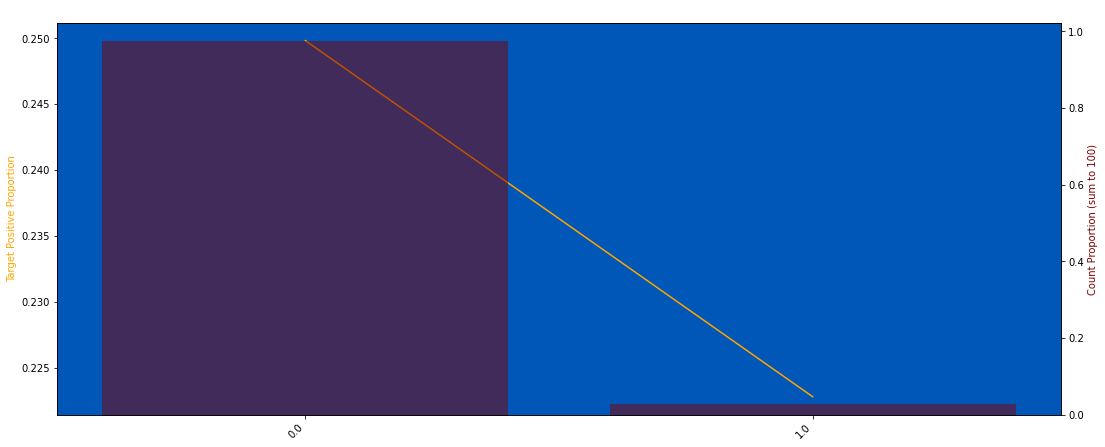

In [101]:
plot_target_check(train, "S_18", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True, without_drop_tail=True)

In [102]:
# plot_train_test_distribution(df_list, "S_18", nunique_thr=150, without_drop_tail=True)

### S_19 (Drop)

In [103]:
%%time
for df in df_list:
    df.drop(columns=["S_19"], inplace=True)

CPU times: user 750 ms, sys: 511 ms, total: 1.26 s
Wall time: 1.26 s


### S_20 @Binary, Increasing

In [104]:
# plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=200)

In [105]:
%%time
df_list = round_dfs(df_list, col="S_20", decimals=1, add_new_col=False)

CPU times: user 918 ms, sys: 1.92 s, total: 2.84 s
Wall time: 3.75 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


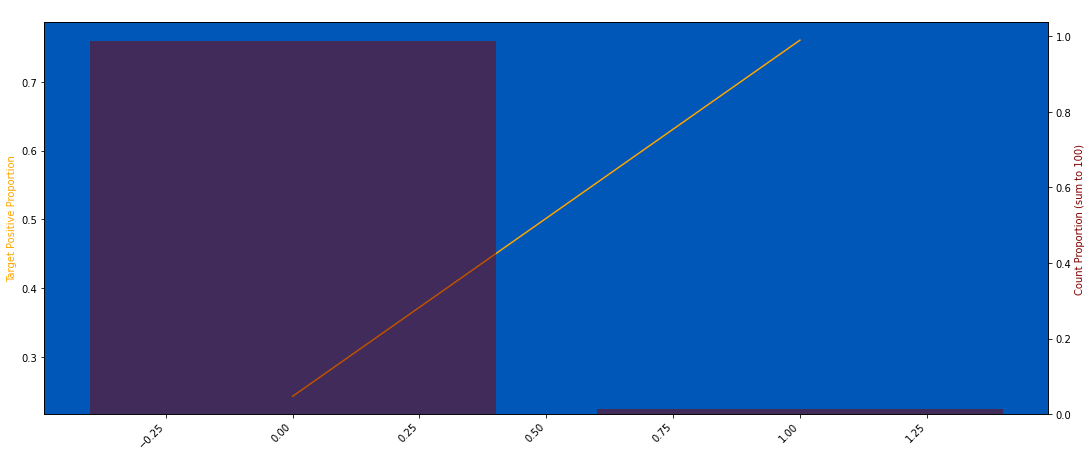

In [106]:
plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=2000, without_drop_tail=True)

In [107]:
# plot_train_test_distribution(df_list, "S_20", nunique_thr=50, without_drop_tail=True)

### S_22 (Drop)

In [108]:
# plot_target_check(train, "S_22", q=50, use_raw_bin=True)

### S_23 @Continuous, High Flat for non-null

In [109]:
# plot_target_check(train, "S_23", q=50, use_raw_bin=True)

In [110]:
print_percentile(df_list, "S_23", 0.1)
describe_all(df_list, "S_23")

0.1th percentile:
train : -0.56
public test : -0.6
private test : -0.59


,train,public test,private test
count,"5,531,006.0000","5,718,672.0000","5,643,549.0000"
mean,0.1747,0.1792,0.1811
std,0.8520,0.7962,0.8180
min,-206.0900,-446.9600,-338.9300
25%,0.1300,0.1300,0.1300
50%,0.1300,0.1300,0.1300
75%,0.1300,0.1300,0.1300
max,885.3300,930.1600,819.0400
null_proportion,0.0001,0.0001,0.0001


In [111]:
for df in df_list:
    df = clip_col(df, "S_23", top_value=2.5, add_new_col=False)
    df = clip_col(df, "S_23", btm_value=-0.6, add_new_col=False)

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


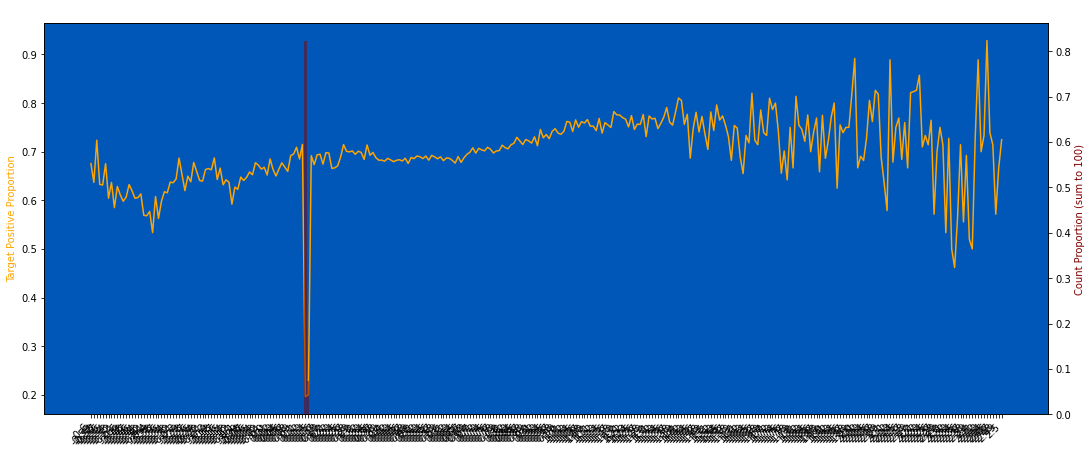

In [112]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1600)

In [113]:
# plot_train_test_distribution(df_list, "S_23", nunique_thr=1600)

### S_24 (Drop)

In [114]:
%%time
for df in df_list:
    df.drop(columns=["S_24"], inplace=True)

CPU times: user 1.1 s, sys: 909 ms, total: 2 s
Wall time: 2 s


### S_25 @Continuous, High Flat

In [115]:
# plot_target_check(train, "S_25", q=50, use_raw_bin=True)

In [116]:
print_percentile(df_list, "S_25", 99.9)
describe_all(df_list, "S_25")

99.9th percentile:
train : 1.32
public test : 1.35
private test : 1.38


,train,public test,private test
count,"5,518,604.0000","5,706,483.0000","5,630,967.0000"
mean,0.9200,0.9182,0.9218
std,0.2068,0.2117,0.2065
min,-2.4600,-2.4600,-2.4600
25%,0.9700,0.9700,0.9700
50%,0.9700,0.9700,0.9700
75%,0.9700,0.9700,0.9700
max,4.0500,3.6700,5.6000
null_proportion,0.0023,0.0023,0.0024


In [117]:
for df in df_list:
    df = clip_col(df, "S_25", top_value=1.38, add_new_col=False)
    df = clip_col(df, "S_25", btm_value=-1.19, add_new_col=False)

12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


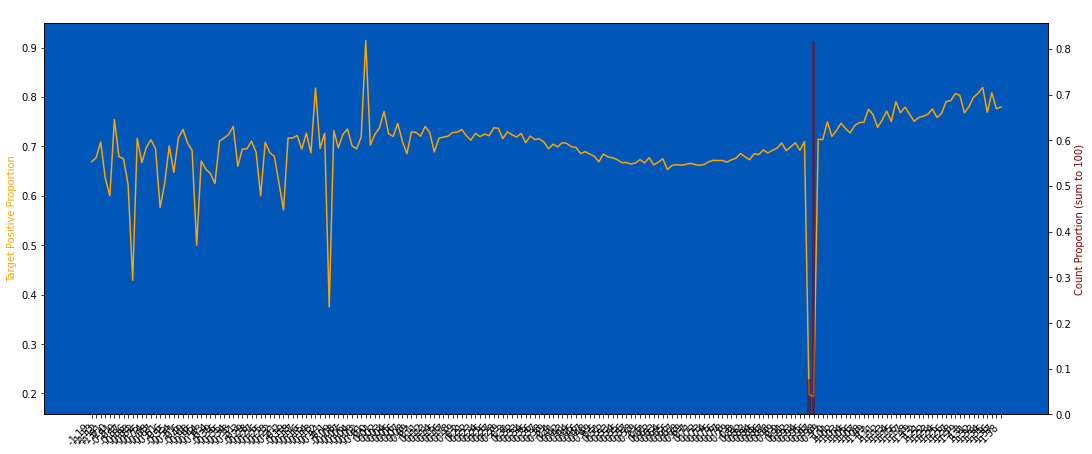

In [118]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [119]:
# plot_train_test_distribution(df_list, "S_25", nunique_thr=1500)

### S_26 @Continuous, Decreasing

In [120]:
# plot_target_check(train, "S_26", q=50, use_raw_bin=True)

In [121]:
print_percentile(df_list, "S_26", 99.9)
describe_all(df_list, "S_26")

99.9th percentile:
train : 4.11
public test : 4.28
private test : 4.6


,train,public test,private test
count,"5,530,817.0000","5,717,254.0000","5,642,742.0000"
mean,0.0618,0.0669,0.0737
std,0.4638,0.5372,0.5213
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0100,0.0100,0.0200
max,136.6600,272.0500,186.6300
null_proportion,0.0001,0.0004,0.0003


In [122]:
for df in df_list:
    df = clip_col(df, "S_26", top_value=4.5, add_new_col=False)

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1


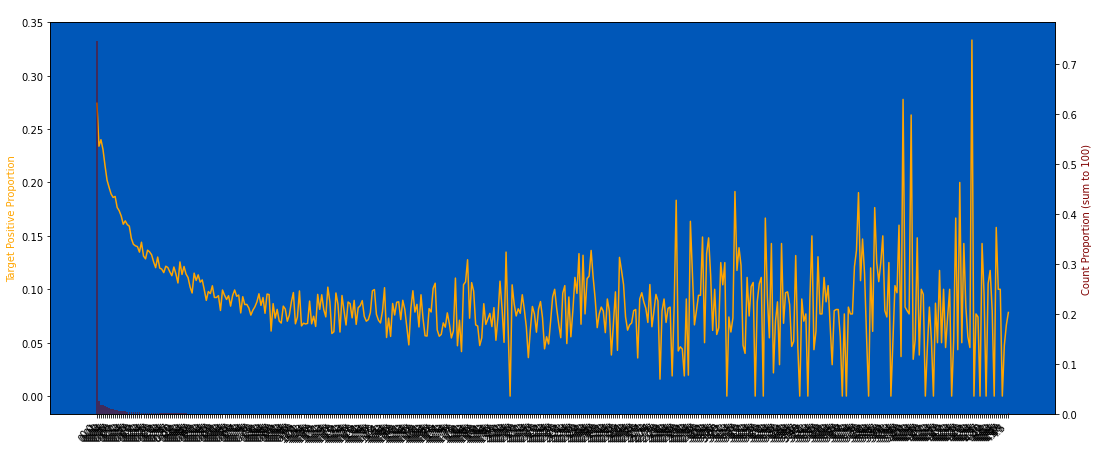

In [123]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

In [124]:
# plot_train_test_distribution(df_list, "S_26", nunique_thr=2000)

### S_27 @Continuous, U

In [125]:
# plot_target_check(train, "S_27", q=50, use_raw_bin=True)

In [126]:
print_percentile(df_list, "S_27", 99.9)
describe_all(df_list, "S_27")

99.9th percentile:
train : 4.37
public test : 4.18
private test : 4.02


,train,public test,private test
count,"4,130,516.0000","4,409,930.0000","4,453,557.0000"
mean,0.2730,0.3185,0.3132
std,0.3250,0.3747,0.3390
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.2900,0.3400,0.3500
75%,0.4400,0.5100,0.5100
max,5.4500,5.4500,5.4500
null_proportion,0.2533,0.2290,0.2110


In [127]:
for df in df_list:
    df = clip_col(df, "S_27", top_value=4, add_new_col=False)

1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1


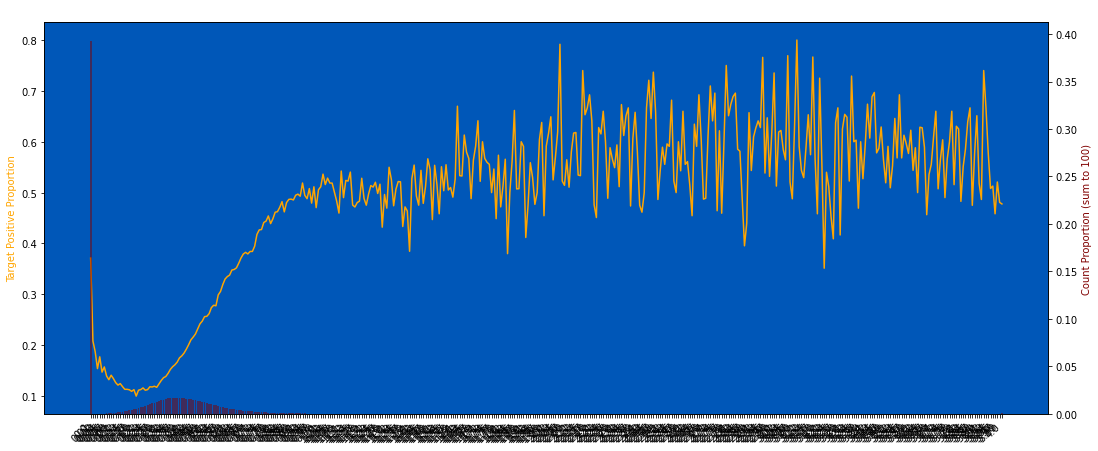

In [128]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

## Spike fix

S_12 (0.001476948719739174, 0.002762973213404889)
0 null count, 0.000 null proportion
nan of the targets have label = 1


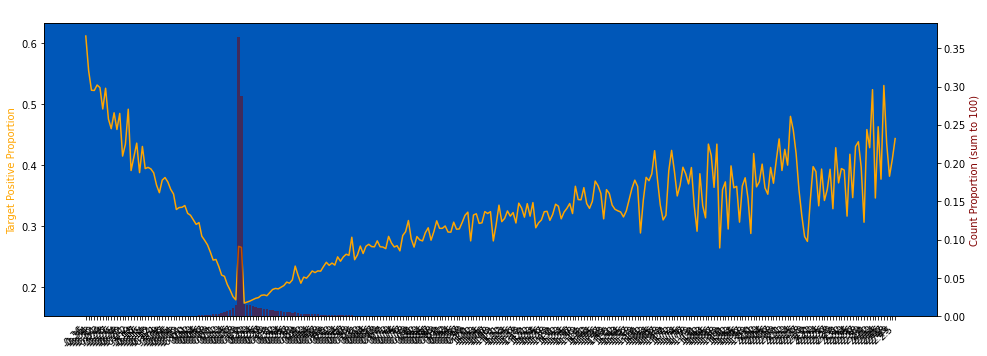

S_23 (0.0017362191796771005, 0.0021563542641862507)
445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


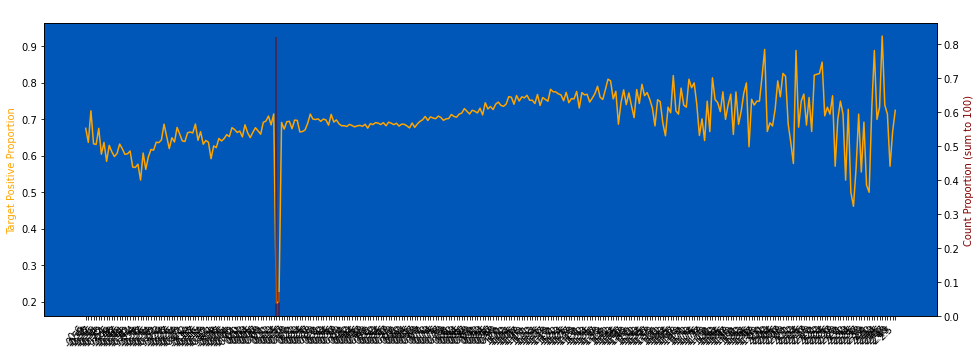

S_25 (0.0018756959734586552, 0.003884592180184359)
12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


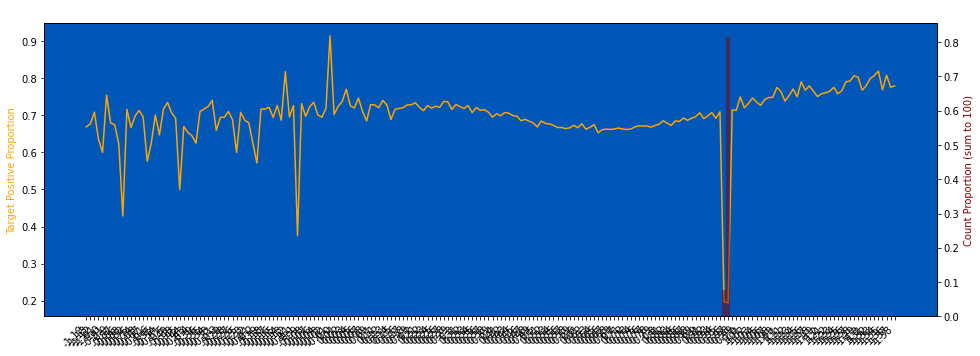

In [129]:
for col in ["S_12", "S_23", "S_25"]:
    print(col, check_psi(df_list, col))
    plot_target_check(train, col, q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, figsize=(16, 6))

### S_12

In [130]:
check_psi(df_list, "S_12")

(0.001476948719739174, 0.002762973213404889)

In [131]:
for df in tqdm(df_list):
    # df["S_12_"] = df["S_12"].values
    special_indices = df.loc[
        (df["S_12"].between(0.18, 0.19))
        & 
        ~(
            (df["S_23"].between(0.13, 0.14))
            | (df["S_25"].between(0.96, 0.97))
        )

    ].index.tolist()
    df.loc[special_indices, "S_12"] = np.nan

100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


362113 null count, 0.065 null proportion
0.7413 of the targets have label = 1


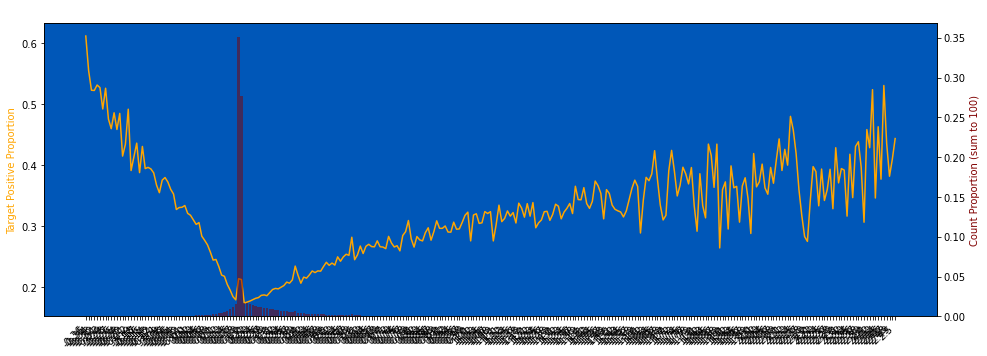

In [132]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, figsize=(16, 6))

In [133]:
check_psi(df_list, "S_12")

(0.001593327577317529, 0.0031851816660778813)

### S_23

In [134]:
check_psi(df_list, "S_23")

(0.0017362191796771005, 0.0021563542641862507)

In [135]:
for df in tqdm(df_list):
    # df["S_23_"] = df["S_23"].values
    special_indices = df.loc[
        (df["S_23"].between(0.13, 0.14))
        & 
        (
            (df["S_12"].isnull())
            | (df["S_22"].between(0.3, 0.31))
            | (df["S_25"].between(0.96, 0.97))
        )

    ].index.tolist()
    df.loc[special_indices, "S_23"] = np.nan

100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


4915198 null count, 0.889 null proportion
0.1929 of the targets have label = 1


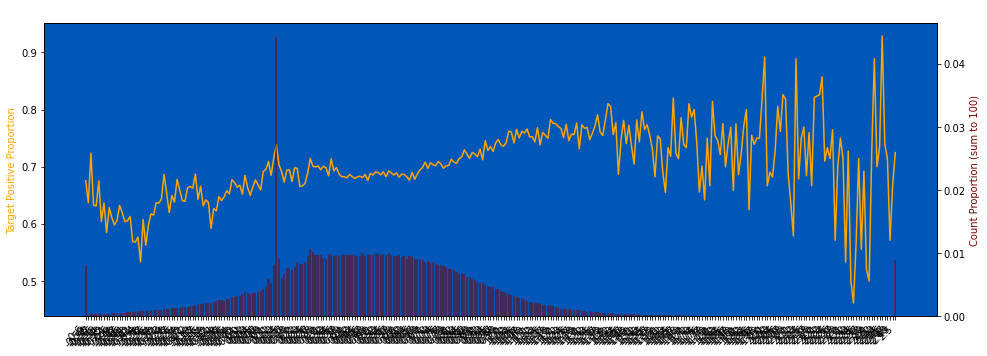

In [136]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, figsize=(16, 6))

In [137]:
check_psi(df_list, "S_23")

(0.001716046321276599, 0.002393407416755405)

### S_25

In [138]:
check_psi(df_list, "S_25")

(0.0018756959734586552, 0.003884592180184359)

In [139]:
for df in tqdm(df_list):
    # df["S_25_"] = df["S_25"].values
    special_indices = df.loc[
        (df["S_25"].between(0.96, 0.97))
        & 
        (
            (df["S_12"].isnull())
            | (df["S_22"].between(0.3, 0.31))
            | (df["S_23"].isnull())
        )

    ].index.tolist()
    df.loc[special_indices, "S_25"] = np.nan

100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


4927576 null count, 0.891 null proportion
0.1941 of the targets have label = 1


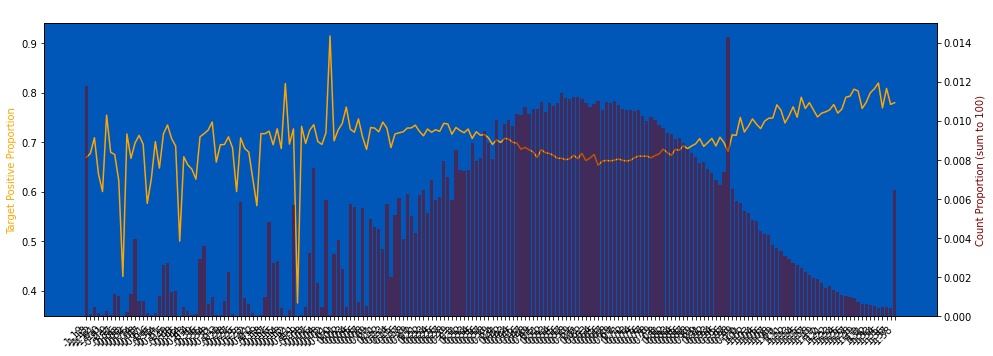

In [140]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, figsize=(16, 6))

In [141]:
check_psi(df_list, "S_25")

(0.0018053148997681648, 0.0039274421404065524)

In [142]:
END = time.time()

In [143]:
print(f"{END - START:.2f} seconds elapsed")

157.95 seconds elapsed


In [144]:
%%time
for df in df_list:
    df.drop(columns=["S_22"], inplace=True)

CPU times: user 721 ms, sys: 441 ms, total: 1.16 s
Wall time: 1.16 s


### Column checking

In [145]:
from tqdm import tqdm

In [146]:
all_columns = get_cols(df_list[0], ("S_", "P_"))
print(all_columns)

['S_2', 'P_2', 'S_3', 'P_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_12', 'S_13', 'S_15', 'P_4', 'S_16', 'S_18', 'S_20', 'S_23', 'S_25', 'S_26', 'S_27', 'P_3a']


In [147]:
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 200].index.tolist()

In [148]:
for col in tqdm(less_unique_d_cols):
    temp = integerize(train[col])
    if (temp - train[col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to integer")
        for df in df_list:
            df[col] = integerize(df[col])

 36%|███▋      | 4/11 [00:00<00:00, 17.58it/s]

S_6 fulfill criteria to convert to integer
S_13 fulfill criteria to convert to integer


 73%|███████▎  | 8/11 [00:01<00:00,  7.15it/s]

S_18 fulfill criteria to convert to integer
S_20 fulfill criteria to convert to integer


100%|██████████| 11/11 [00:02<00:00,  5.19it/s]


In [149]:
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

P_2 fulfill criteria to convert to float32
S_3 fulfill criteria to convert to float32
P_3 fulfill criteria to convert to float32
S_5 fulfill criteria to convert to float32
S_7 fulfill criteria to convert to float32
S_8 fulfill criteria to convert to float32
S_12 fulfill criteria to convert to float32
S_15 fulfill criteria to convert to float32
P_4 fulfill criteria to convert to float32
S_16 fulfill criteria to convert to float32
S_23 fulfill criteria to convert to float32
S_25 fulfill criteria to convert to float32
S_26 fulfill criteria to convert to float32
S_27 fulfill criteria to convert to float32
temp fulfill criteria to convert to float32
P_3a fulfill criteria to convert to float32


In [150]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp']

In [151]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

CPU times: user 787 ms, sys: 289 ms, total: 1.08 s
Wall time: 1.07 s


### Verify if all columns have been clipped

In [152]:
for col in tqdm(df_list[0].columns):
    if col in NON_FEATURE_COLUMNS:
        continue
    if not (df_list[0][col].min() == df_list[1][col].min() == df_list[2][col].min()):
        print(f"Min of column {col} is different: {df_list[0][col].min()}, {df_list[1][col].min()}, {df_list[2][col].min()}")
    
    if not (df_list[0][col].max() == df_list[1][col].max() == df_list[2][col].max()):
        print(f"Max of column {col} is different: {df_list[0][col].max()}, {df_list[1][col].max()}, {df_list[2][col].max()}")

100%|██████████| 24/24 [00:01<00:00, 15.51it/s]


In [153]:
for col in tqdm(df_list[0].columns):
    if col in NON_FEATURE_COLUMNS:
        continue
    if check_psi(df_list, col)[1] >= 0.1:
        print(f"Column {col} has feature drift of {check_psi(df_list, col)[1]} on train x private-test")

100%|██████████| 24/24 [00:14<00:00,  1.61it/s]


In [154]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 7.39 s, sys: 815 ms, total: 8.21 s
Wall time: 8.2 s


In [155]:
train.shape, test.shape

((5531451, 24), (11363762, 23))

In [156]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

(1.446220247, 2.511391546)

In [157]:
train.columns

Index(['customer_ID', 'row_number', 'row_number_inv', 'S_2', 'P_2', 'S_3',
       'P_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_12', 'S_13', 'S_15', 'P_4',
       'S_16', 'S_18', 'S_20', 'S_23', 'S_25', 'S_26', 'S_27', 'target',
       'P_3a'],
      dtype='object')

In [158]:
%%time
train.to_parquet(f"./train_parquet/train_spend_payment.parquet")
test.to_parquet(f"./test_parquet/test_spend_payment.parquet")

CPU times: user 11.8 s, sys: 669 ms, total: 12.4 s
Wall time: 11.3 s
